In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets, utils
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np

In [2]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [3]:
EPOCHS     = 40
BATCH_SIZE = 64

In [5]:
transform_train = transforms.Compose([

    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
transform_test = transforms.Compose([
    transforms.ToTensor()
])

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(
        root      = './data_CIFAR10',
        train     = True,
        download  = True,
        transform = transform_train),
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(
        root      = './data_CIFAR10',
        train     = False,
        download  = True,
        transform = transform_test),
    batch_size=BATCH_SIZE,
    shuffle=True
)

100%|██████████| 170498071/170498071 [00:05<00:00, 29408762.88it/s]


Extracting ./data_CIFAR10/cifar-10-python.tar.gz to ./data_CIFAR10
Files already downloaded and verified


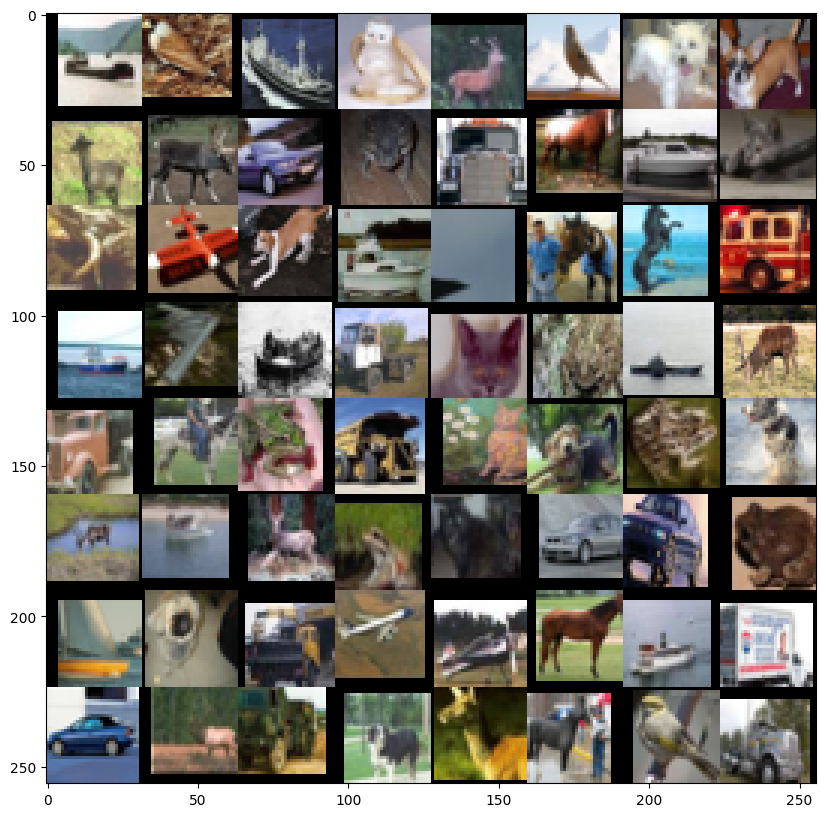

[[' ship' ' bird' ' ship' '  cat' ' deer' ' bird' '  dog' '  dog']
 [' deer' ' deer' '  car' ' frog' 'truck' 'horse' ' ship' '  cat']
 [' frog' 'plane' '  dog' ' ship' 'plane' 'horse' 'horse' 'truck']
 [' ship' 'plane' ' ship' 'truck' '  cat' ' frog' ' ship' ' deer']
 ['truck' 'horse' ' frog' 'truck' '  cat' '  dog' ' frog' '  dog']
 [' deer' ' ship' ' deer' ' frog' '  cat' '  car' '  car' ' frog']
 [' ship' '  dog' 'truck' 'plane' 'plane' 'horse' ' ship' 'truck']
 ['  car' ' deer' 'truck' '  cat' ' deer' 'horse' ' bird' 'truck']]


In [6]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
img   = utils.make_grid(images, padding=0)
npimg = img.numpy()
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()
classes = np.array(['plane', '  car', ' bird', '  cat', ' deer',
                    '  dog', ' frog', 'horse', ' ship', 'truck'])
print(classes[labels.reshape((8, 8))])

In [10]:
import torchvision

model = torchvision.models.resnet18(pretrained=True).to(DEVICE)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [12]:
num_ftrs = model.fc.in_features # fc의 입력 노드 수를 산출 (512개)
model.fc = nn.Linear(num_ftrs, 10) # fc를 nn.Linear(num_ftrs, 10)로 대체
model = model.to(DEVICE)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


In [13]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [14]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [15]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()

            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [16]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)

    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.730085
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.099997
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.948498
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.897244
[1] Test Loss: 0.8987, Accuracy: 68.96%
Train Epoch: 2 [0/50000 (0%)]	Loss: 0.686120
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.673103
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.784092
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.889365
[2] Test Loss: 0.6936, Accuracy: 75.75%
Train Epoch: 3 [0/50000 (0%)]	Loss: 0.947076
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.629743
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.750335
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.470158
[3] Test Loss: 0.6458, Accuracy: 77.90%
Train Epoch: 4 [0/50000 (0%)]	Loss: 0.722680
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.557032
Train Epoch: 4 [25600/50000 (51%)]	Loss: 0.653154
Train Epoch: 4 [38400/50000 (77%)]	Loss: 0.593581
[4] Test Loss: 0.7110, Accuracy: 75.89%
Train Epoch: 5 [0/50000 (0%)]	Loss: 0.539308
Train Epoch: 5 

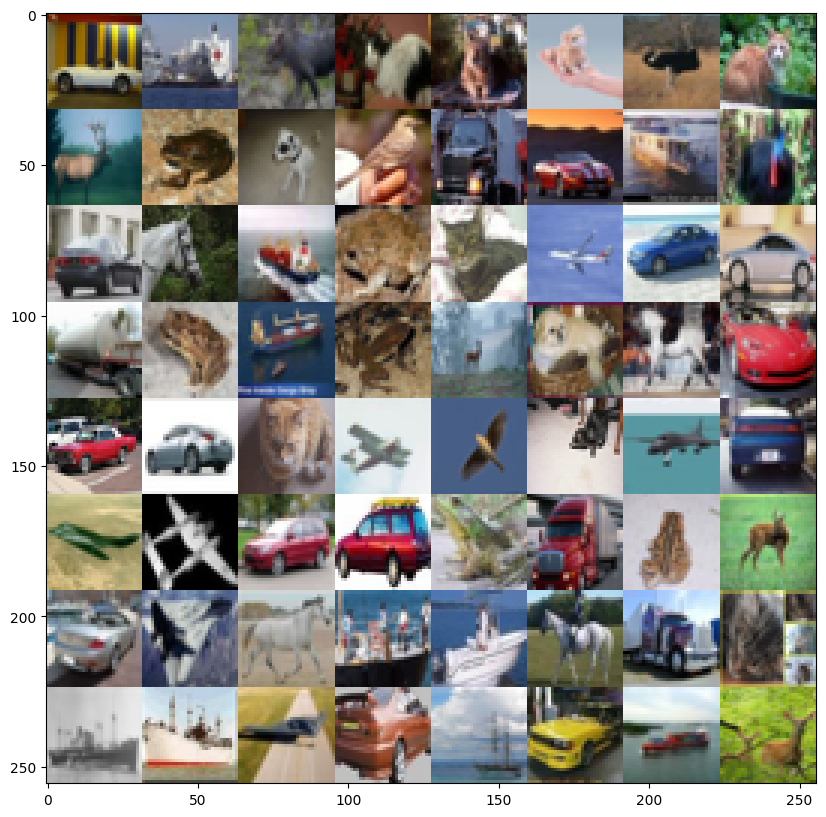

your predict : 
[['truck' ' ship' ' deer' '  cat' '  dog' ' bird' ' bird' ' bird']
 [' ship' ' frog' '  dog' '  cat' 'truck' '  car' 'truck' '  car']
 ['  car' '  cat' 'truck' ' frog' ' frog' 'plane' ' ship' '  car']
 ['truck' ' frog' ' bird' ' frog' 'plane' '  cat' '  dog' '  car']
 ['  car' '  car' '  cat' 'plane' ' bird' ' bird' 'plane' 'truck']
 ['plane' '  dog' '  car' '  car' ' frog' 'truck' '  cat' 'horse']
 ['  car' 'horse' 'horse' '  car' ' ship' 'horse' 'truck' '  dog']
 [' ship' 'plane' ' bird' 'truck' ' ship' '  car' ' ship' ' frog']]

answer : 
[['  car' ' ship' ' deer' '  cat' '  cat' '  cat' ' bird' '  cat']
 [' deer' ' frog' '  dog' ' bird' 'truck' '  car' ' ship' ' bird']
 ['  car' 'horse' ' ship' ' frog' '  cat' 'plane' '  car' '  car']
 ['truck' ' frog' ' ship' ' frog' ' deer' '  dog' 'horse' '  car']
 ['  car' '  car' '  cat' 'plane' ' bird' '  cat' 'plane' '  car']
 ['plane' 'plane' '  car' '  car' ' frog' 'truck' ' frog' ' deer']
 ['  car' 'plane' 'horse' ' ship' 

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
img   = utils.make_grid(images, padding=0)
npimg = img.numpy()
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()
your_predict = model(images.to(DEVICE)).max(1)[1].view(8, 8).cpu()
answer = labels.reshape((8, 8))
correct = your_predict == answer
print("your predict : ")
print(classes[your_predict])
print("\nanswer : ")
print(classes[answer])
print("\ncorrectness :", correct.sum().item()/64)
print(correct)